<a href="https://colab.research.google.com/github/callee2006/MachineLearning/blob/master/Generative%20Adversarial%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Vanilla GANs model
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [0]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [0]:
import torch
import torchvision
import torch.nn as nn

In [0]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [0]:
import numpy as np
import datetime
import os, sys

In [0]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [15]:
MODEL_NAME = 'GAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE =",DEVICE)

DEVICE = cuda


In [0]:
# G: generator
def get_sample_image(G, n_noise):
    """
        synthesize samples from random noise
    """
    z = torch.randn(100, n_noise).to(DEVICE)     # generate 100 random noise vectors
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])        # 10x10 grid to tile 100 images on 
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

**get_sample_image**: GAN 모델 학습 후에 Generator가 이미지를 잘 만드는지 확인하기 위한 함수

**Line 5**: Generator의 input으로 사용될 noise를 배치 사이즈만큼 sampling 한다.

**Line 6**: Generator의 output을 이미지 형태로 reshape한다.

**Line 7**: gpu에 있는 데이터를 cpu로 가져오고 graph와 관계없이 데이터 자체에 대해서 numpy로 변환한다.

**Line 8**: 시각화를 위해 저장할 배열 선언

**Line 9-10**: 만들어낸 이미지 100장에 대해서 시각화하기 위해 (8)에서 선언한 배열에 반복적으로 부분 저장

![](https://github.com/callee2006/pytorch-practice/blob/master/assets/GAN.jpg?raw=1)

In [0]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

**Discriminator**: GAN의 Discriminator model architecture 정의. Fully-connected layer 3개로 구성. 마지막은 확률로 나타내기 위해 sigmoid 사용

In [0]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

**Generator**: 일반적으로 Generator는 Discriminator보다 학습하기 어려우므로 더 깊게 FC layer 5개로 구성.

In [0]:
# dimension of noise vector
n_noise = 100

In [0]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

각각 모델을 메모리에 올리는 작업

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                                ]
)

**transforms** torchvision에서 제공하는 transform 함수들이 있는 패키지.

**ToTensor**는 numpy array를 torch tensor로 변환.

**Normalize**는 다음과 같이 계산함. input[channel] = (input[channel] - mean[channel]) / std[channel]

In [0]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

GAN에서는 noise sample로부터 새로운 이미지를 만들어내는 작업이기 때문에 따로 test set을 불러올 필요가 없음.

In [0]:
batch_size = 64

In [0]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

**DataLoader**는 pytorch에서 학습 시에 데이터를 배치 사이즈만큼씩 효율적으로 불러오도록 돕는 클래스. 잘 사용할수록 GPU의 사용률이 올라간다.

**shuffle**: every epochs 마다 데이터의 순서를 랜덤하게 섞는다.

**drop_last**: 데이터의 개수가 배치 사이즈로 나눠떨어지지 않는 경우, 마지막 배치를 버린다. 주로 학습시에만 사용.

In [0]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

**GAN objective**

$$\min_G \max_D V(D,G) = \mathbb{E}_{x\sim p_{data}~(x)}[log D(x)] + \mathbb{E}_{z\sim p_x(z)}[log(1-D(G(z)))]$$

**nn.BCELoss**: Binary Cross Entropy

$$-{[y\log(\hat{y}) + (1 - y)\log(1 - \hat{y})]}$$

**ADAM betas**: exponential decay rates for the moment estimates. (default: (0.9, 0.999))

$$\beta_1, \beta_2 \in [0,1)$$

In [0]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [0]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

Discriminator를 학습할 때는 **D(x)**는 1이 나오도록 **D(G(z))**에 대해서는 0이 나오도록,

Generator를 학습할 때는 **D(G(z))**에 대해 1이 나오도록 학습하기 위해 Discriminator의 label 준비

In [0]:
if not os.path.exists('samples'):
    os.makedirs('samples')

### Training Code



**line 2**: GAN에서는 MNIST의 class가 필요없으므로 image만 취함.

**line 4-6**: Real sample **x**에 대해 D를 forward하고 loss 계산

**line 8-10**: Fake sample **G(z)**에 대해 D를 forward하고 loss 계산

**line 11**: 위 2개의 loss를 합산

**line 13-15**: gradient 초기화 --> backward하면서 계산 --> parameter 업데이트

**line 17**: GAN에서 gradient를 계산하는 방법은 Discriminator에 의존하므로 D를 잘 학습시키기 위해 G보다 여러번 학습시키는 테크닉. W-GAN에서 사용

**line 19-25**: Generator를 위해 (8-10)과 반대로 loss를 계산하는 부분. non saturating loss **-log(D(G(z)))**를 사용하는 이유는 아래 언급함.

**line 21**: 이론적으로 **log(1-D(G(z)))**를 minimize하는 것이 맞으나, 학습 초기에 G가 이미지를 잘 만들지 못해 gradient가 작은 문제로 saturate 될 수 있으므로, 그 대안으로 제시된 것이 **log(D(G(z)))**를 maximize하는 것이다.

**line 30-34**: 1000 step마다 Generator가 학습이 잘 되고 있는지 샘플 이미지 만들어서 저장

In [0]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/50, Step: 110500, D Loss: 1.3896421194076538, G Loss: 0.690558135509491
Epoch: 0/50, Step: 111000, D Loss: 1.3983235359191895, G Loss: 0.6896148920059204
Epoch: 1/50, Step: 111500, D Loss: 1.391947865486145, G Loss: 0.6903558969497681
Epoch: 1/50, Step: 112000, D Loss: 1.3964734077453613, G Loss: 0.6896278262138367
Epoch: 2/50, Step: 112500, D Loss: 1.3860523700714111, G Loss: 0.6903901696205139
Epoch: 2/50, Step: 113000, D Loss: 1.3976752758026123, G Loss: 0.6920679807662964
Epoch: 3/50, Step: 113500, D Loss: 1.3921983242034912, G Loss: 0.6904454827308655
Epoch: 3/50, Step: 114000, D Loss: 1.3983021974563599, G Loss: 0.6908710598945618
Epoch: 4/50, Step: 114500, D Loss: 1.3950172662734985, G Loss: 0.6898924708366394
Epoch: 5/50, Step: 115000, D Loss: 1.3955379724502563, G Loss: 0.6903975009918213
Epoch: 5/50, Step: 115500, D Loss: 1.3986783027648926, G Loss: 0.6901401281356812
Epoch: 6/50, Step: 116000, D Loss: 1.398795485496521, G Loss: 0.6919378042221069
Epoch: 6/50, Step: 

## Visualize Sample

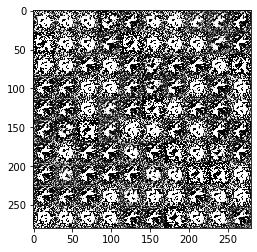

In [57]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [0]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')